參考資料
https://github.com/emadRad/lstm-gru-pytorch/blob/master/lstm_gru.ipynb

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt



cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
from models_morvan import *

In [3]:
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [11]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10
 
#model = LSTMModel2(input_dim, hidden_dim, layer_dim, output_dim)
#model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)
model = AlvinLSTM(input_dim, hidden_dim, layer_dim, output_dim)
#model = AlvinGRU(input_dim, hidden_dim, layer_dim, output_dim)



#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()
     
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
print(model)

AlvinLSTM(
  (rnn): LSTM(28, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
'''
STEP 7: TRAIN THE MODEL
'''
 
# Number of steps to unroll
seq_dim = 28 

loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
          
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
          
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.297656536102295. Accuracy: 19
Iteration: 1000. Loss: 1.1159789562225342. Accuracy: 63
Iteration: 1500. Loss: 0.31331688165664673. Accuracy: 85
Iteration: 2000. Loss: 0.3302156925201416. Accuracy: 92
Iteration: 2500. Loss: 0.14482979476451874. Accuracy: 94
Iteration: 3000. Loss: 0.0698518306016922. Accuracy: 95
Iteration: 3500. Loss: 0.23129604756832123. Accuracy: 96
Iteration: 4000. Loss: 0.04215792194008827. Accuracy: 96
Iteration: 4500. Loss: 0.2770622968673706. Accuracy: 96
Iteration: 5000. Loss: 0.06275377422571182. Accuracy: 97
Iteration: 5500. Loss: 0.03732646629214287. Accuracy: 97
Iteration: 6000. Loss: 0.08635803312063217. Accuracy: 97


In [14]:
predicted

tensor([8, 9, 0, 1, 6, 7, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 9, 1,
        9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 8, 9, 1, 4,
        0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2,
        4, 9, 4, 2, 4, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
        3, 4, 5, 6], device='cuda:0')

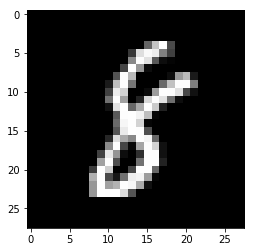

In [15]:
plt.imshow(images[0].cpu(), cmap='gray')

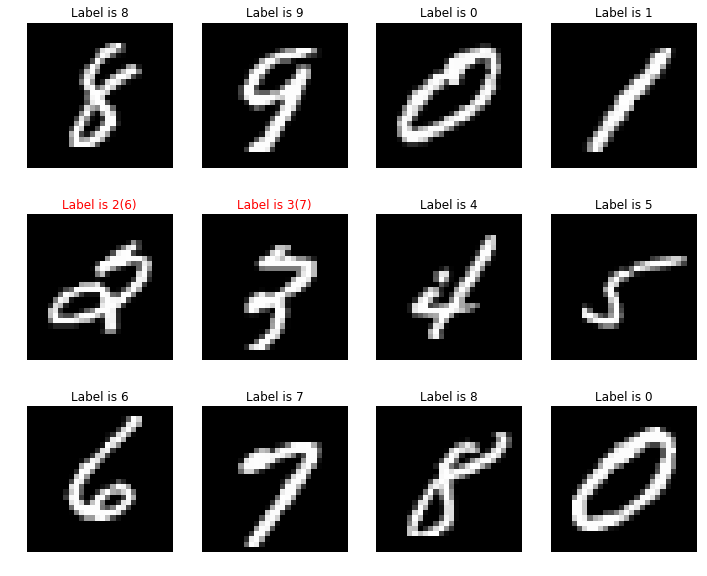

In [17]:
plt.figure(figsize=(12,10)) 

def plot_mnist(index):
    ax = plt.subplot(3,4,index+1) 
    plt.axis('off')
    if predicted[index].cpu() == labels[index]:
        plt.title('Label is {pred}'.format(pred=predicted[index].cpu()))
    else:
        plt.title('Label is {label}({pred})'.format(pred=predicted[index].cpu(),label=labels[index]), color='red')

    plt.imshow(images[index].cpu(), cmap='gray') 
    
for i,data in enumerate(images,0): 
    if i == 3: break 
    plot_mnist(0+i*4)
    plot_mnist(1+i*4)
    plot_mnist(2+i*4)
    plot_mnist(3+i*4)
